# 🤖 Model Training and Evaluation

This notebook focuses on training and evaluating an XGBoost model to predict sales for Rossmann stores using time-aware cross-validation and a set of engineered features.


In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt


## 📥 Step 1: Load Preprocessed Data

We load the cleaned and feature-rich dataset created in the previous step.


In [2]:
df = pd.read_csv("~/rossmann-sales-forecast/data/processed/train_processed.csv")


/tmp/ipykernel_11611/2567785627.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("~/rossmann-sales-forecast/data/processed/train_processed.csv")


## 🧾 Step 2: Select Features and Target

We define the feature set and target variable (`Sales`) for modeling.


In [3]:
features = ['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday', 'Month', 'Day', 'Year',
            'Sales_lag_1', 'Sales_lag_7', 'Sales_lag_14', 'Sales_roll_7', 'Sales_roll_14']
target = 'Sales'
X = df[features]
y = df[target]


## 🔍 Step 3: Model Setup with TimeSeriesSplit and Hyperparameter Tuning

We use `TimeSeriesSplit` for time-aware cross-validation and perform a randomized search over a parameter grid for the XGBoost model.


In [4]:
tscv = TimeSeriesSplit(n_splits=3)
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 201, 50),
    'max_depth': np.arange(3, 11),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': np.linspace(0.5, 1.0, 6)
}

search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

search.fit(X, y)
best_model = search.best_estimator_
print("Best parameters:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.2677777777777778}


## 🧪 Step 4: Final Evaluation on Last Fold

We train the best model on the training portion of the last fold and evaluate on the test set.


In [5]:
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 746.08
RMSE: 1042.42


## 💾 Step 5: Save Trained Model

The final trained XGBoost model is saved for deployment and inference.


In [7]:
import joblib
joblib.dump(best_model, "/home/amanda/rossmann-sales-forecast/models/xgb_model.pkl")


['/home/amanda/rossmann-sales-forecast/models/xgb_model.pkl']

## 📊 Step 6: Visualize Predictions vs Actual Sales

We plot a comparison of the actual vs predicted values for a subset of the test data.


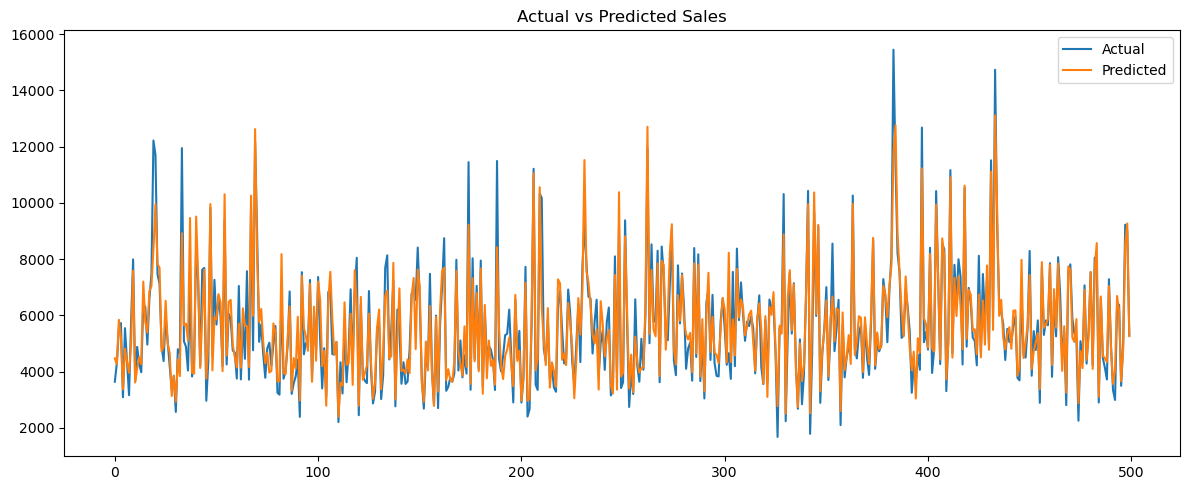

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.tight_layout()
plt.show()
